<a href="https://colab.research.google.com/github/saketkc/pyro-rethinking/blob/master/Chapters/05_Chapter05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 05 - Multivariate Linear Models

In [ ]:
!pip install torch torchvision pyro-ppl proplot black blackcellmagic

     |████████████████████████████████| 522kB 2.7MB/s 
     |████████████████████████████████| 7.9MB 13.1MB/s 
     |████████████████████████████████| 102kB 10.9MB/s 
     |████████████████████████████████| 747kB 41.7MB/s 
  Created wheel for blackcellmagic: filename=blackcellmagic-0.0.2-cp36-none-any.whl size=3087 sha256=a58675975ff956dce7c7de1ba8e317796dc6f214a105760d53591c5ab0eb6b45
  Stored in directory: /root/.cache/pip/wheels/b3/0d/de/2877216e31162d9a3f680ca36540af18563f6fc1c36d84c198
Successfully built blackcellmagic


In [ ]:
%load_ext blackcellmagic
import warnings

import pandas as pd
import proplot as plot
import pyro
import pyro.distributions as dist
import pyro.infer
import pyro.ops.stats as stats
import pyro.optim
import seaborn as sns
import torch
import torch.distributions.constraints as constraints
import torch.tensor as tensor
from pyro.contrib.autoguide import AutoLaplaceApproximation

warnings.filterwarnings("ignore")
%pylab inline
pyro.set_rng_seed(42)

plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["font.weight"] = "bold"

/usr/local/lib/python3.6/dist-packages/proplot/config.py:1454: ProPlotWarning: Rebuilding font cache.


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


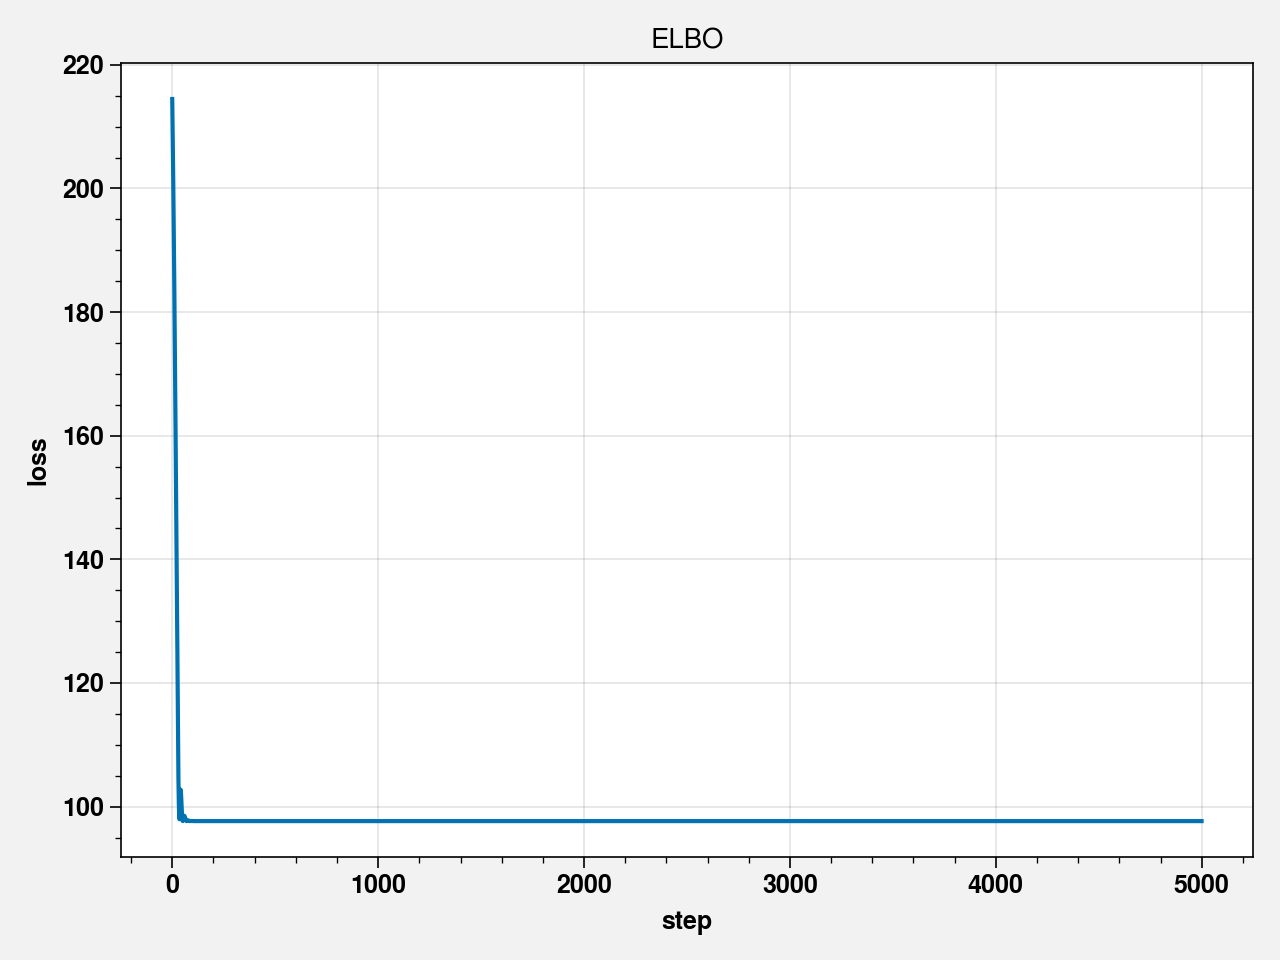

In [ ]:
waffle_divorce = pd.read_csv("https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/WaffleDivorce.csv", sep=";")
d = waffle_divorce
# standardize predictor

d['MedianAgeMarriage_s'] = (d.MedianAgeMarriage - d.MedianAgeMarriage.mean())/d.MedianAgeMarriage.std()

def model51(MedianAgeMarriage_s):
  
  a = pyro.sample("a", dist.Normal(tensor(10.), tensor(10.)))
  bA = pyro.sample("bA", dist.Normal(tensor(0.), tensor(1.)))
  sigma = pyro.sample("sigma", dist.Uniform(tensor(0.), tensor(50.)))
  mu = a + bA * MedianAgeMarriage_s

  divorce = pyro.sample("divorce", dist.Normal(mu, sigma))
  return divorce 

def link(laplace_guide, data, num_samples):
  pred = pyro.infer.Predictive(laplace_guide, num_samples=num_samples)
  samples = pred.get_samples()
  mu = samples["bA"].detach().reshape((num_samples,1))*data.reshape(1, data.shape[0]) + samples["a"].detach().reshape((num_samples,1))
  return mu

divorce = tensor(d.Divorce, dtype=torch.float)
MedianAgeMarriage_s = tensor(d['MedianAgeMarriage_s'], dtype=torch.float)

conditioned51 = pyro.condition(model51, data={"divorce": divorce})
guide51 = pyro.infer.autoguide.AutoLaplaceApproximation(conditioned51)
pyro.clear_param_store()

svi = pyro.infer.SVI(
    model=conditioned51,
    guide=guide51,
    optim=pyro.optim.Adam({"lr": 0.1}),
    loss=pyro.infer.Trace_ELBO(),
)
num_steps = 5000
losses = [svi.step(MedianAgeMarriage_s) for t in range(num_steps)]
plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")
plt.tight_layout()
laplace_guide51 = guide51.laplace_approximation(MedianAgeMarriage_s)
pred51 = pyro.infer.Predictive(laplace_guide51, num_samples=1000)  

# Code 5.2

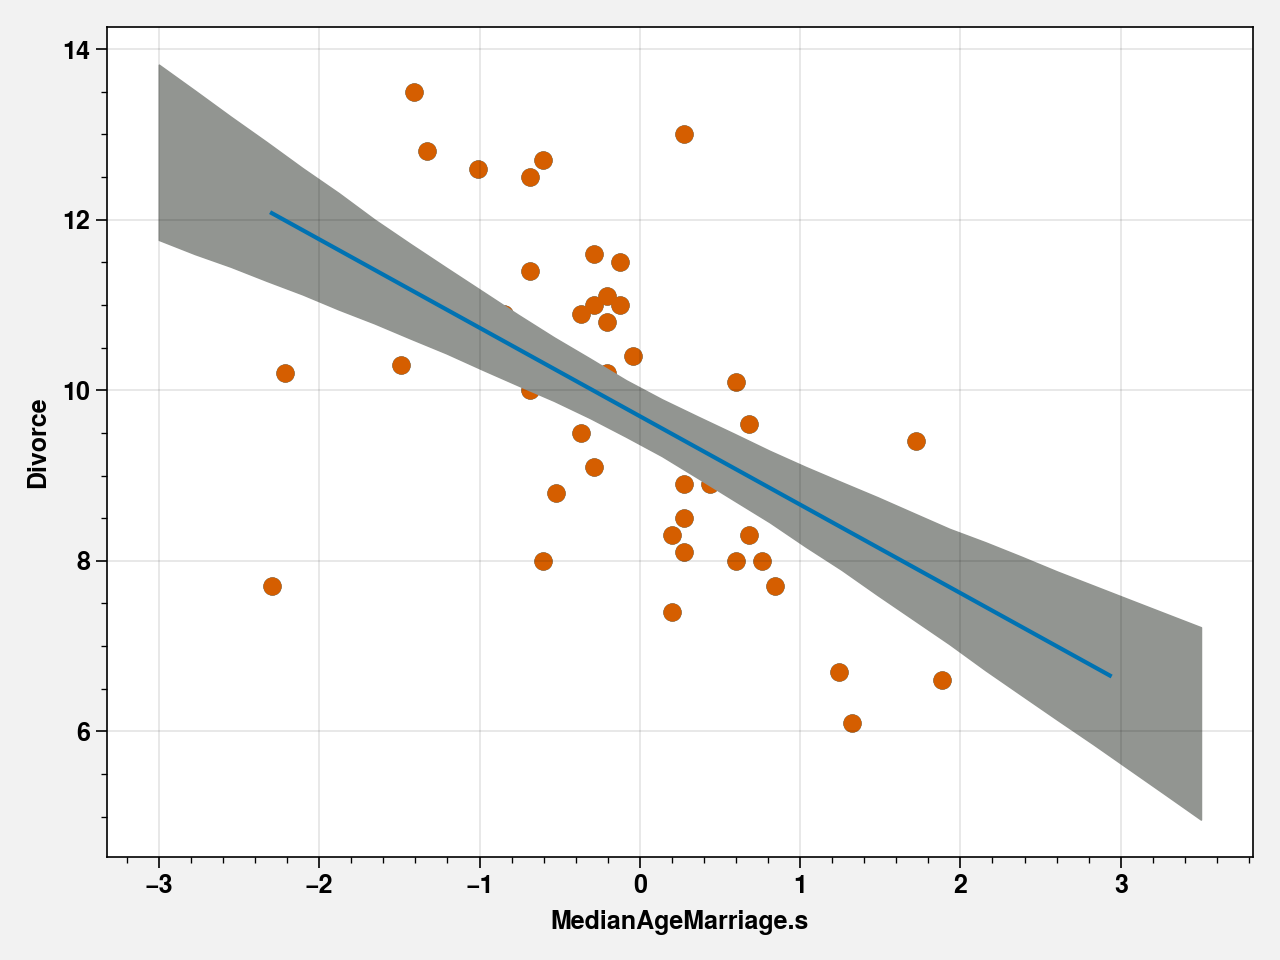

In [ ]:
mam_seq = torch.linspace(-3., 3.5, steps=30)
mu = link(laplace_guide51, mam_seq, 1000)
mu_PI = stats.pi(mu, dim=0, prob=0.89)

fig, ax = plt.subplots()
ax.scatter(waffle_divorce['MedianAgeMarriage_s'], waffle_divorce['Divorce'])

x = waffle_divorce['MedianAgeMarriage_s'].sort_values()
y = tensor(waffle_divorce['MedianAgeMarriage_s'].sort_values()) * pred51.get_samples()["bA"].detach().mean() + pred51.get_samples()["a"].detach().mean()
ax.scatter(waffle_divorce['MedianAgeMarriage_s'], waffle_divorce['Divorce'])
ax.plot(x,y)
ax.fill_between(mam_seq, mu_PI[0], mu_PI[1], color='gray')
ax.set_xlabel("MedianAgeMarriage.s")
ax.set_ylabel('Divorce')
fig.tight_layout()

# Code 5.3


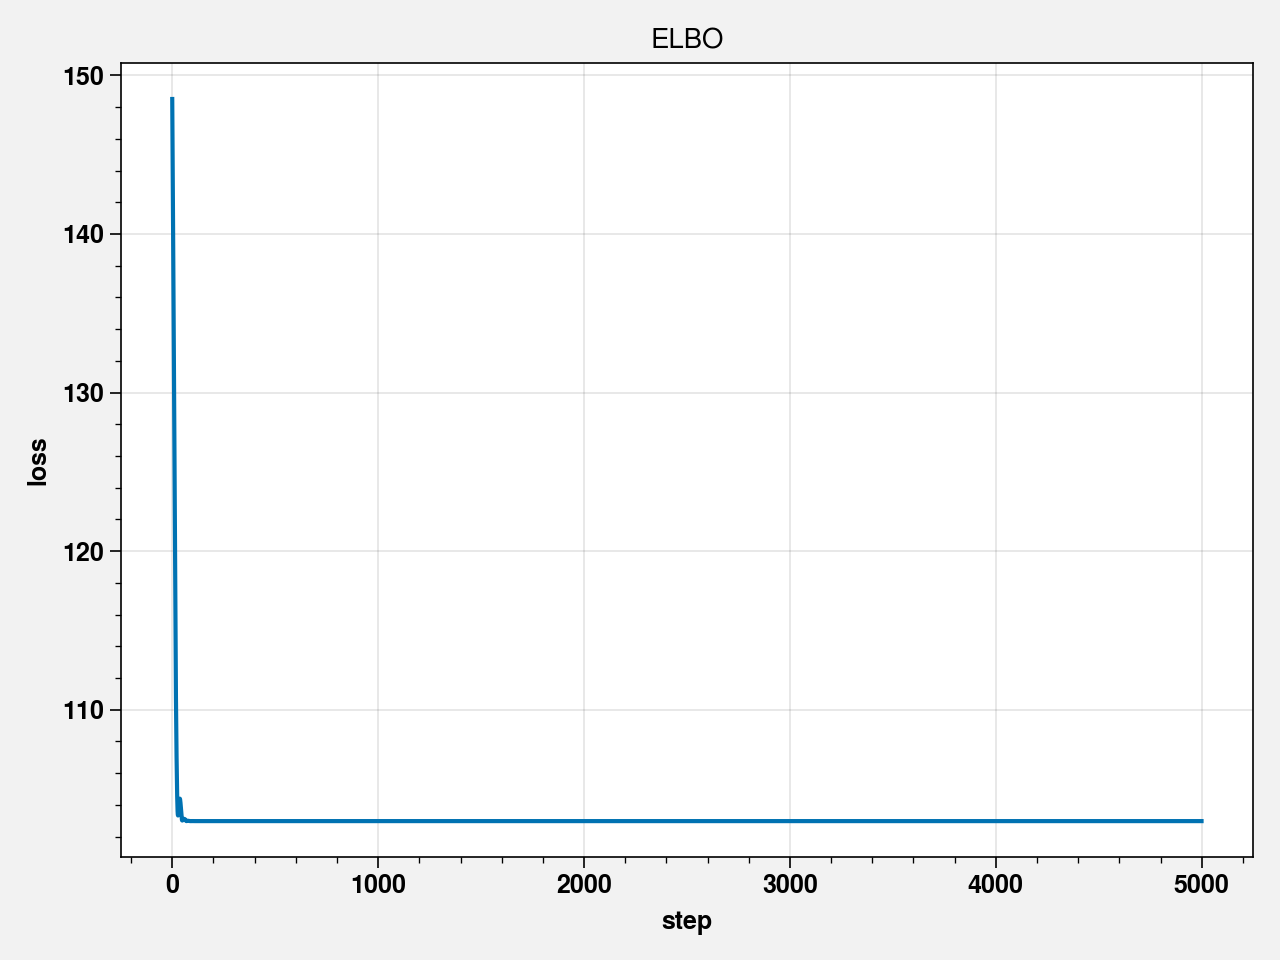

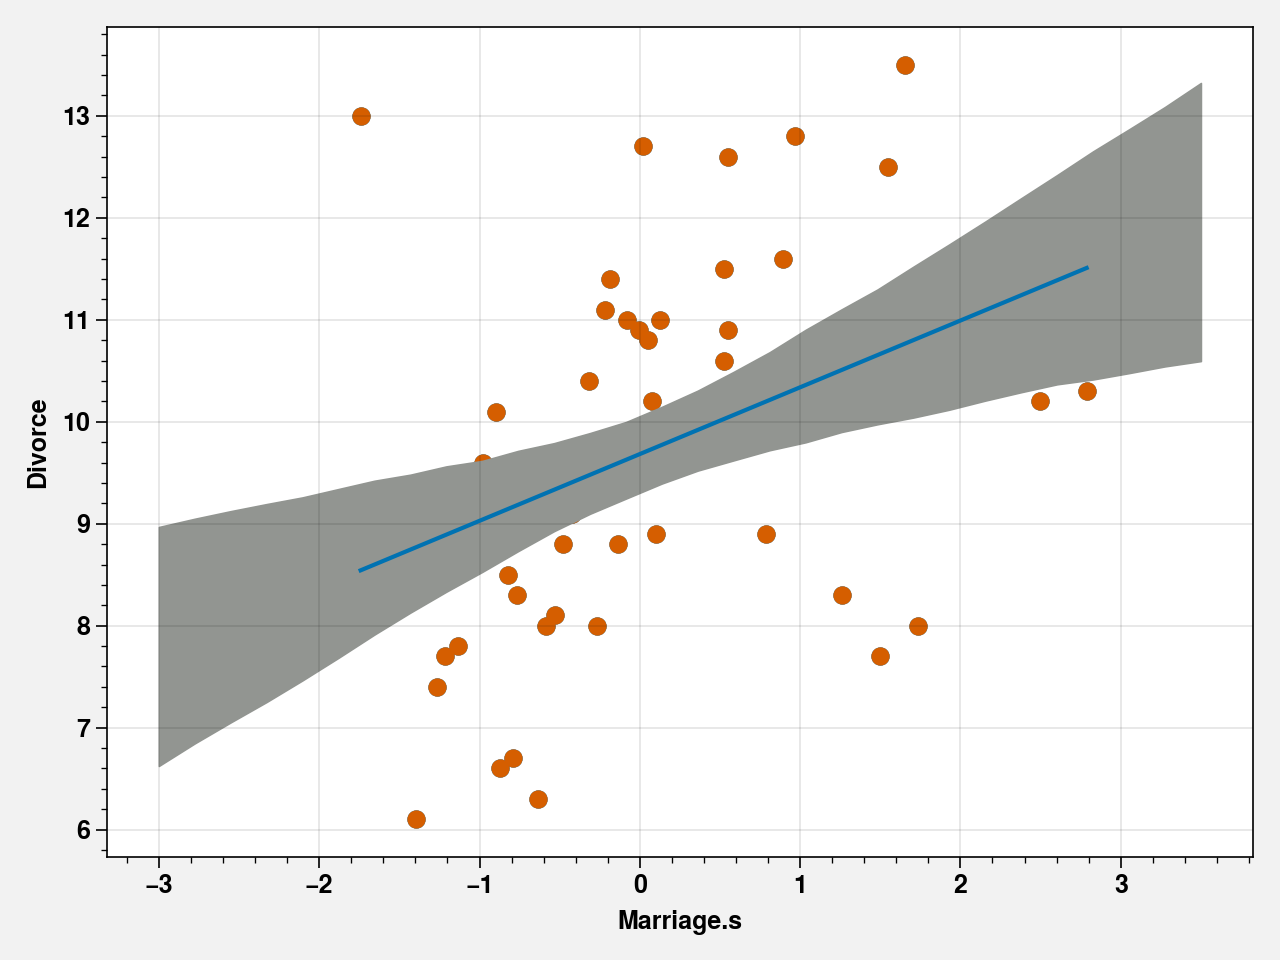

In [ ]:
d['Marriage_s'] = (d.Marriage - d.Marriage.mean())/d.Marriage.std()

def model52(Marriage_s):
  
  a = pyro.sample("a", dist.Normal(tensor(10.), tensor(10.)))
  bR = pyro.sample("bR", dist.Normal(tensor(0.), tensor(1.)))
  sigma = pyro.sample("sigma", dist.Uniform(tensor(0.), tensor(10.)))
  mu = a + bR * Marriage_s

  divorce = pyro.sample("divorce", dist.Normal(mu, sigma))
  return divorce 

def link(laplace_guide, data, num_samples):
  pred = pyro.infer.Predictive(laplace_guide, num_samples=num_samples)
  samples = pred.get_samples()
  mu = samples["bR"].detach().reshape((num_samples,1))*data.reshape(1, data.shape[0]) + samples["a"].detach().reshape((num_samples,1))
  return mu

divorce = tensor(d.Divorce, dtype=torch.float)
Marriage_s = tensor(d['Marriage_s'], dtype=torch.float)

conditioned52 = pyro.condition(model52, data={"divorce": divorce})
guide52 = pyro.infer.autoguide.AutoLaplaceApproximation(conditioned52)
pyro.clear_param_store()

svi = pyro.infer.SVI(
    model=conditioned52,
    guide=guide52,
    optim=pyro.optim.Adam({"lr": 0.1}),
    loss=pyro.infer.Trace_ELBO(),
)
num_steps = 5000
losses = [svi.step(Marriage_s) for t in range(num_steps)]
plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")
plt.tight_layout()
laplace_guide52 = guide52.laplace_approximation(Marriage_s)
pred52 = pyro.infer.Predictive(laplace_guide52, num_samples=1000)  


mam_seq = torch.linspace(-3., 3.5, steps=30)
mu = link(laplace_guide52, mam_seq, 1000)
mu_PI = stats.pi(mu, dim=0, prob=0.89)

fig, ax = plt.subplots()
ax.scatter(waffle_divorce['Marriage_s'], waffle_divorce['Divorce'])

x = waffle_divorce['Marriage_s'].sort_values()
y = tensor(waffle_divorce['Marriage_s'].sort_values()) * pred52.get_samples()["bR"].detach().mean() + pred52.get_samples()["a"].detach().mean()
ax.scatter(waffle_divorce['Marriage_s'], waffle_divorce['Divorce'])
ax.plot(x,y)
ax.fill_between(mam_seq, mu_PI[0], mu_PI[1], color='gray')
ax.set_xlabel("Marriage.s")
ax.set_ylabel('Divorce')
fig.tight_layout()

# Code 5.4

In [ ]:
def summary(samples, prob=0.95):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0).data.numpy(),
            "std": torch.std(v, 0).data.numpy(),
            "{:.1f}%".format(100 * (1 - prob)): v.kthvalue(
                int(len(v) * (1 - prob)), dim=0
            )[0].data.numpy(),
            "{:.1f}%".format(100 * prob): v.kthvalue(int(len(v) * prob), dim=0)[
                0
            ].data.numpy(),
        }
    return pd.DataFrame(site_stats)


def model53(Marriage_s, MedianAgeMarriage_s):
  
  a = pyro.sample("a", dist.Normal(tensor(10.), tensor(10.)))
  bA = pyro.sample("bA", dist.Normal(tensor(0.), tensor(1.)))
  bR = pyro.sample("bR", dist.Normal(tensor(0.), tensor(1.)))
  sigma = pyro.sample("sigma", dist.Uniform(tensor(0.), tensor(10.)))
  mu = a + bR * Marriage_s + bA * MedianAgeMarriage_s

  divorce = pyro.sample("divorce", dist.Normal(mu, sigma))
  return divorce 

divorce = tensor(d.Divorce, dtype=torch.float)
Marriage_s = tensor(d['Marriage_s'], dtype=torch.float)
MedianAgeMarriage_s = tensor(d['MedianAgeMarriage_s'], dtype=torch.float)

conditioned53 = pyro.condition(model53, data={"divorce": divorce})
guide53 = pyro.infer.autoguide.AutoLaplaceApproximation(conditioned53)
pyro.clear_param_store()

svi = pyro.infer.SVI(
    model=conditioned53,
    guide=guide53,
    optim=pyro.optim.Adam({"lr": 0.1}),
    loss=pyro.infer.Trace_ELBO(),
)
num_steps = 5000
losses = [svi.step(Marriage_s, MedianAgeMarriage_s) for t in range(num_steps)]
laplace_guide53 = guide53.laplace_approximation(Marriage_s, MedianAgeMarriage_s)
pred53 = pyro.infer.Predictive(laplace_guide53, num_samples=1000)  
summary(pred53.get_samples()) 

,_AutoMultivariateNormal_latent,a,bA,bR,sigma
mean,"[9.687267, -1.1342475, -0.13712633, -1.7718284]",9.68726,-1.1342468,-0.1371263,1.459392
std,"[0.20480353, 0.28206912, 0.2890895, 0.119306594]",0.20480353,0.28206912,0.2890895,0.14808053
5.0%,"[9.35909, -1.6078639, -0.5914301, -1.9622669]",9.35909,-1.6078639,-0.5914301,1.2322193
95.0%,"[10.019775, -0.6550522, 0.33545357, -1.5797188]",10.019775,-0.6550522,0.33545357,1.708353


# Code 5.5

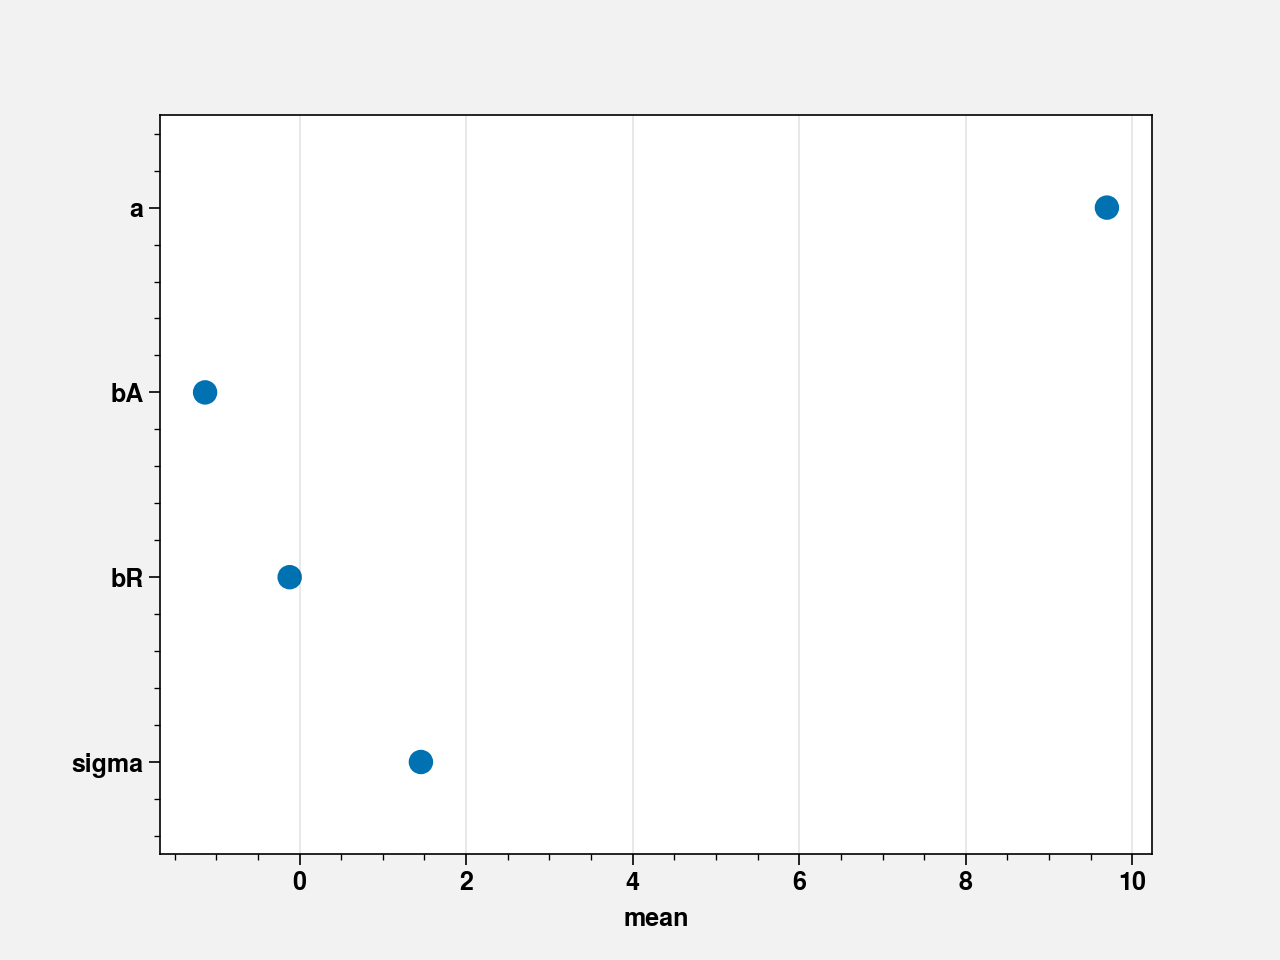

In [46]:
precis = summary(pred53.get_samples())
precis = precis.drop(columns = ["_AutoMultivariateNormal_latent"]).T
fig, ax = plt.subplots()
sns.pointplot(precis["mean"], precis.index, join=False, ax=ax)
#for i, param in enumerate(precis.index):
#  sns.lineplot(precis.loc[param, ["5.0%", "95.0%"]], [i, i], color="k", ax=ax)

In [44]:
precis.loc[param, ["5.0%", "95.0%"]]

5.0%       9.36519
95.0%    10.033953
Name: a, dtype: object

In [45]:
i

0